### Multinomial NaiveBayes Classifier to classify Fusion Tickets

In [1]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

#### Import Important Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

#### Import Important Class and Functions

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### Import Dataset

In [4]:
df_FIN=pd.read_excel('./FIN_AUG_SEP.xlsx',encoding='utf-8')

In [5]:
df_SCM=pd.read_excel('./SCM_AUG_SEP.xlsx',encoding='utf-8')

In [17]:
list_df=[df_FIN,df_SCM]

In [18]:
df=pd.concat(list_df,axis=0)

In [19]:
print(len(df.index))

23865


In [20]:
df.columns=df.columns.astype('str')

In [21]:
df=df.drop_duplicates().reset_index(drop=True)

In [22]:
df.columns=df.columns.astype(str)

In [23]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [24]:
df.columns

Index(['Bugged', 'Severity', 'Product_Family', 'Product_Area', 'Product_ID',
       'Product', 'Component', 'Sub_Component', 'Product_Version',
       'Root_Cause', 'SR', 'Known_Issue', 'Reason_Code', 'Summary', 'Status',
       'Substatus', 'Last_Updated_On', 'Date_Opened', 'Days_Open',
       'Date_Closed'],
      dtype='object')

In [26]:
list(df.Root_Cause.unique())

['Cloud-Post Go Live',
 'Cloud-Implementation',
 'Cloud-Provisioning',
 'Cloud-Special Events',
 'Software-Maintain',
 'Cust Engmt - Customer/Partner',
 'Software-Install',
 'Cust Engmt - Development',
 'Software-Upgrade',
 'Hardware',
 'Cust Engmt - Support',
 '3-17922331161',
 '3-18307149679',
 '3-18260575351',
 'Yes',
 '3-18201600121',
 'SR Link',
 '3-18246699141']

In [15]:
df=df[~df.Root_Cause.isin(['3-17922331161','3-18307149679','3-18260575351','Yes','3-18201600121','SR Link','3-18246699141'])]

In [16]:
df.Root_Cause.describe()

count                    23857
unique                      11
top       Cloud-Implementation
freq                     14734
Name: Root_Cause, dtype: object

In [195]:
df_prod_group=df[['Root_Cause','Product_Family','Product_Area']].groupby(['Root_Cause','Product_Family'],as_index=False).count().sort_values('Product_Area',ascending=False).reset_index(drop=True)

### Text Classification

In [196]:
df.Summary=df.Summary.apply(lambda x : str(x))
df

,Bugged,Severity,Product_Family,Product_Area,Product_ID,Product,Component,Sub_Component,Product_Version,Root_Cause,Known_Issue,Reason_Code,Summary,Status,Substatus,Last_Updated_On,Date_Opened,Days_Open,Date_Closed
0,No,4-Minimal,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Accounting and Reporting Sequences,11.12.1.0.0,Cloud-Post Go Live,Unspecified,13 Documentation,Creation of account and account code combination,Closed,Resolved with Solution,2018-08-29 19:26:25,2018-08-22 07:01:15,7,2018-08-29 14:52:48
1,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Invoices-Audit Invoices,Manage Payables Invoices,11.13.18.02.0,Cloud-Post Go Live,Yes,"14 Undetermined,Cust Abandoned",[IMPL SPT] An application error occurred on ed...,Closed,No fault found,2018-08-24 18:38:19,2018-08-10 08:46:14,7,2018-08-17 16:29:01
2,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.12.1.0.0,Cloud-Implementation,Yes,01 Product Defects,We can not do the drilldown from the defined f...,Closed,Resolved with Solution,2018-08-02 01:40:04,2018-07-25 16:15:11,7,2018-08-01 23:47:24
3,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Ledgers and Balancing Segment Value Ass...,11.13.18.02.0,Cloud-Post Go Live,Yes,07 Setup / Configuration,Remove the assigned balancing segment from a l...,Closed,Resolved with Workaround,2018-08-23 16:39:27,2018-08-09 06:18:46,7,2018-08-16 13:49:48
4,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Accounts Payable Balances-Close Payable...,Manage Payables Accounting Periods,11.13.18.02.0,Cloud-Post Go Live,No,07 Setup / Configuration,Unable to activate AP Journal Entry Rule Set X...,Closed,Resolved with Solution,2018-09-06 16:39:41,2018-08-23 07:46:37,7,2018-08-30 15:15:14
5,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10418,Oracle Fusion Receivables Cloud Service,Setup Module,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,Unspecified,01 Product Defects,"""Cannot insert record more than once"" on loadi...",Closed,Resolved with Workaround,2018-08-14 17:44:58,2018-07-31 07:19:34,7,2018-08-07 14:49:06
6,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10403,Oracle Fusion Financials Common Module Cloud S...,Functional Setup Manager,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,Yes,07 Setup / Configuration,How to create common Lookup under Common Looku...,Closed,Resolved with Solution,2018-09-05 02:31:52,2018-08-21 16:55:38,7,2018-08-29 00:16:36
7,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.13.18.02.0,Cloud-Post Go Live,Unspecified,07 Setup / Configuration,Unable to use Smartview post R13 upgrade,Closed,No fault found,2018-08-30 19:17:42,2018-08-23 07:33:12,7,2018-08-30 14:46:26
8,No,1-Critical,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Create and Manage Journals,Manage Journals,11.13.18.02.0,Cloud-Implementation,Yes,"05 Performance, Sizing",Cannot Open Journal Page (Error 504),Closed,No fault found,2018-08-23 13:40:13,2018-08-09 03:37:10,7,2018-08-16 10:49:54
9,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Payments-Prepare and Record Payments,Manage Payables Payments,11.13.18.02.0,Cloud-Post Go Live,No,02 Enhancement Requests,Single Consolidated payment for Multiple Busin..

In [197]:
df.Summary=df.Summary.apply(lambda x : x.encode('ascii',errors='ignore').decode())

In [198]:
list_nonchar=['_','-','[',']',':',')','~','(','.',',','\"','\'','/','{','}','%','?','0','1','2','3','4','5','6','7','8','9']
df

,Bugged,Severity,Product_Family,Product_Area,Product_ID,Product,Component,Sub_Component,Product_Version,Root_Cause,Known_Issue,Reason_Code,Summary,Status,Substatus,Last_Updated_On,Date_Opened,Days_Open,Date_Closed
0,No,4-Minimal,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Accounting and Reporting Sequences,11.12.1.0.0,Cloud-Post Go Live,Unspecified,13 Documentation,Creation of account and account code combination,Closed,Resolved with Solution,2018-08-29 19:26:25,2018-08-22 07:01:15,7,2018-08-29 14:52:48
1,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Invoices-Audit Invoices,Manage Payables Invoices,11.13.18.02.0,Cloud-Post Go Live,Yes,"14 Undetermined,Cust Abandoned",[IMPL SPT] An application error occurred on ed...,Closed,No fault found,2018-08-24 18:38:19,2018-08-10 08:46:14,7,2018-08-17 16:29:01
2,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.12.1.0.0,Cloud-Implementation,Yes,01 Product Defects,We can not do the drilldown from the defined f...,Closed,Resolved with Solution,2018-08-02 01:40:04,2018-07-25 16:15:11,7,2018-08-01 23:47:24
3,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Ledgers and Balancing Segment Value Ass...,11.13.18.02.0,Cloud-Post Go Live,Yes,07 Setup / Configuration,Remove the assigned balancing segment from a l...,Closed,Resolved with Workaround,2018-08-23 16:39:27,2018-08-09 06:18:46,7,2018-08-16 13:49:48
4,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Accounts Payable Balances-Close Payable...,Manage Payables Accounting Periods,11.13.18.02.0,Cloud-Post Go Live,No,07 Setup / Configuration,Unable to activate AP Journal Entry Rule Set X...,Closed,Resolved with Solution,2018-09-06 16:39:41,2018-08-23 07:46:37,7,2018-08-30 15:15:14
5,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10418,Oracle Fusion Receivables Cloud Service,Setup Module,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,Unspecified,01 Product Defects,"""Cannot insert record more than once"" on loadi...",Closed,Resolved with Workaround,2018-08-14 17:44:58,2018-07-31 07:19:34,7,2018-08-07 14:49:06
6,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10403,Oracle Fusion Financials Common Module Cloud S...,Functional Setup Manager,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,Yes,07 Setup / Configuration,How to create common Lookup under Common Looku...,Closed,Resolved with Solution,2018-09-05 02:31:52,2018-08-21 16:55:38,7,2018-08-29 00:16:36
7,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.13.18.02.0,Cloud-Post Go Live,Unspecified,07 Setup / Configuration,Unable to use Smartview post R13 upgrade,Closed,No fault found,2018-08-30 19:17:42,2018-08-23 07:33:12,7,2018-08-30 14:46:26
8,No,1-Critical,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Create and Manage Journals,Manage Journals,11.13.18.02.0,Cloud-Implementation,Yes,"05 Performance, Sizing",Cannot Open Journal Page (Error 504),Closed,No fault found,2018-08-23 13:40:13,2018-08-09 03:37:10,7,2018-08-16 10:49:54
9,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Payments-Prepare and Record Payments,Manage Payables Payments,11.13.18.02.0,Cloud-Post Go Live,No,02 Enhancement Requests,Single Consolidated payment for Multiple Busin..

In [199]:
def replace(list_nc):
    for text in df:
        for char in list_nc:
            df.Summary=df.Summary.apply(lambda x : x.replace(char, ' '))

In [200]:
replace(list_nonchar)

In [201]:
df_dict=df[['Summary','Root_Cause']]
df_dict

,Summary,Root_Cause
0,Creation of account and account code combination,Cloud-Post Go Live
1,IMPL SPT An application error occurred on ed...,Cloud-Post Go Live
2,We can not do the drilldown from the defined f...,Cloud-Implementation
3,Remove the assigned balancing segment from a l...,Cloud-Post Go Live
4,Unable to activate AP Journal Entry Rule Set X...,Cloud-Post Go Live
5,Cannot insert record more than once on loadi...,Cloud-Post Go Live
6,How to create common Lookup under Common Looku...,Cloud-Post Go Live
7,Unable to use Smartview post R upgrade,Cloud-Post Go Live
8,Cannot Open Journal Page Error,Cloud-Implementation
9,Single Consolidated payment for Multiple Busin...,Cloud-Post Go Live


In [202]:
df_dict['text'] = df_dict['Summary'].astype(str)

In [203]:
df_dict=df_dict.drop(columns=['Summary'])

In [204]:
df_dict.text=df_dict.text.apply(lambda x : x.lower())

In [205]:
df_dict.head()

,Root_Cause,text
0,Cloud-Post Go Live,creation of account and account code combination
1,Cloud-Post Go Live,impl spt an application error occurred on ed...
2,Cloud-Implementation,we can not do the drilldown from the defined f...
3,Cloud-Post Go Live,remove the assigned balancing segment from a l...
4,Cloud-Post Go Live,unable to activate ap journal entry rule set x...


In [206]:
df_dict.text=df_dict.text.str.replace('\d+', '')

In [207]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [208]:
def preprocess(document, lemma=True):
    document = document.lower()
    words = word_tokenize(document)
    words = [word for word in words if word not in stopwords.words("english")]
    if lemma:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    else:
        words = [stemmer.stem(word) for word in words]
    document = " ".join(words)
    return document

In [141]:
df_dict.text=df_dict.text.apply(lambda x : preprocess(x))

In [142]:
df_dict.head()

,Root_Cause,text
0,Cloud-Post Go Live,creation account account code combination
1,Cloud-Post Go Live,impl spt application error occur edit distribu...
2,Cloud-Implementation,drilldown define financial report
3,Cloud-Post Go Live,remove assign balance segment legal entity
4,Cloud-Post Go Live,unable activate ap journal entry rule set xla


In [143]:
df_dict.groupby('Root_Cause').describe()

text         \
                               count unique   
Root_Cause                                    
3-18201600121                      1      1   
3-18246699141                      1      1   
Cloud-Implementation           14734  13438   
Cloud-Post Go Live              5777   5152   
Cloud-Provisioning              1467   1322   
Cloud-Special Events             408    373   
Cust Engmt - Customer/Partner    394    376   
Cust Engmt - Development          39     37   
Cust Engmt - Support              30     29   
Hardware                          10      9   
SR Link                            1      1   
Software-Install                 323    297   
Software-Maintain                607    540   
Software-Upgrade                  68     66   

                                                                                  \
                                                                             top   
Root_Cause                                                                         
3-18201600121                                                              close   
3-18246699141                                                              close   
Cloud-Implementation                                         restrict sr content   
Cloud-Post Go Live                                           restrict sr content   
Cloud-Provisioning                                           restrict sr content   
Cloud-Special Events                                         restrict sr content   
Cust Engmt - Customer/Partner  unable find intercompany organization provider...   
Cust Engmt - Development       find account hub report cloud service menu imp...   
Cust Engmt - Support           ecee test remove edit distributions option inv...   
Hardware                                        uk environment r release version   
SR Link                                                         customer abandon   
Software-Install                                                                   
Software-Maintain                                      add printer test instance   
Software-Upgrade                           error prompt createquickinvoices xlsm   

                                    
                              freq  
Root_Cause                          
3-18201600121                    1  
3-18246699141                    1  
Cloud-Implementation           248  
Cloud-Post Go Live              80  
Cloud-Provisioning              21  
Cloud-Special Events             8  
Cust Engmt - Customer/Partner    2  
Cust Engmt - Development         2  
Cust Engmt - Support             2  
Hardware                         2  
SR Link                          1  
Software-Install                 2  
Software-Maintain                2  
Software-Upgrade                 2

In [145]:
df_dict.head()

,Root_Cause,text
0,Cloud-Post Go Live,creation account account code combination
1,Cloud-Post Go Live,impl spt application error occur edit distribu...
2,Cloud-Implementation,drilldown define financial report
3,Cloud-Post Go Live,remove assign balance segment legal entity
4,Cloud-Post Go Live,unable activate ap journal entry rule set xla


In [146]:
word_dist=pd.DataFrame(pd.Series(' '.join(df_dict.text).split()).value_counts()).reset_index(drop=False)

In [147]:
word_dist=word_dist.rename(columns={'index':'word',0:'freq'})

In [148]:
wldf=word_dist

In [149]:
wldf

,word,freq
0,error,3080
1,invoice,2834
2,impl,2402
3,account,2384
4,spt,2359
5,create,2261
6,order,2100
7,unable,1971
8,report,1807
9,approval,1236


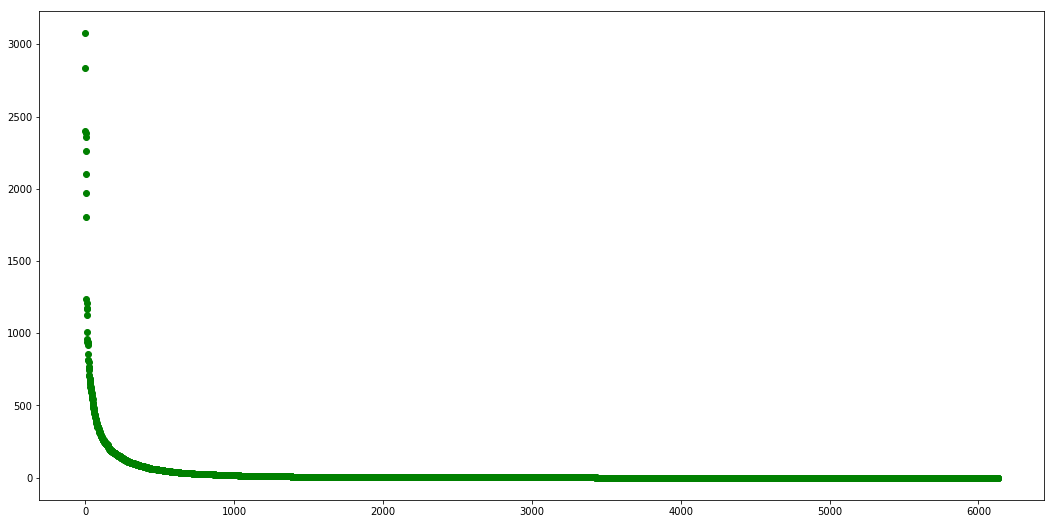

In [150]:
plt.figure(figsize=(18,9))
plt.scatter(x=wldf.index,y=wldf.freq,c='g')

In [151]:
wldf.head()

,word,freq
0,error,3080
1,invoice,2834
2,impl,2402
3,account,2384
4,spt,2359


In [152]:
wldf.tail()

,word,freq
6129,edsv,1
6130,tasklist,1
6131,technologies,1
6132,acccount,1
6133,categorization,1


In [153]:
len(wldf.index)

6134

In [154]:
print(len(wldf[wldf.freq<2]))
print(len(wldf[wldf.freq>4000]))

2703
0


In [155]:
wldf_new=wldf[~wldf.freq.isin(wldf.freq.iloc[:7])]
wldf_new=wldf_new[~wldf_new.freq.isin(['1'])]

In [156]:
def rem_words(list_name):
    for i in list_name:
        if len(i)==1:
            list_name.remove(i)
        #elif len(i)==2:
        #    list_name.remove(i)
    return(list_name)

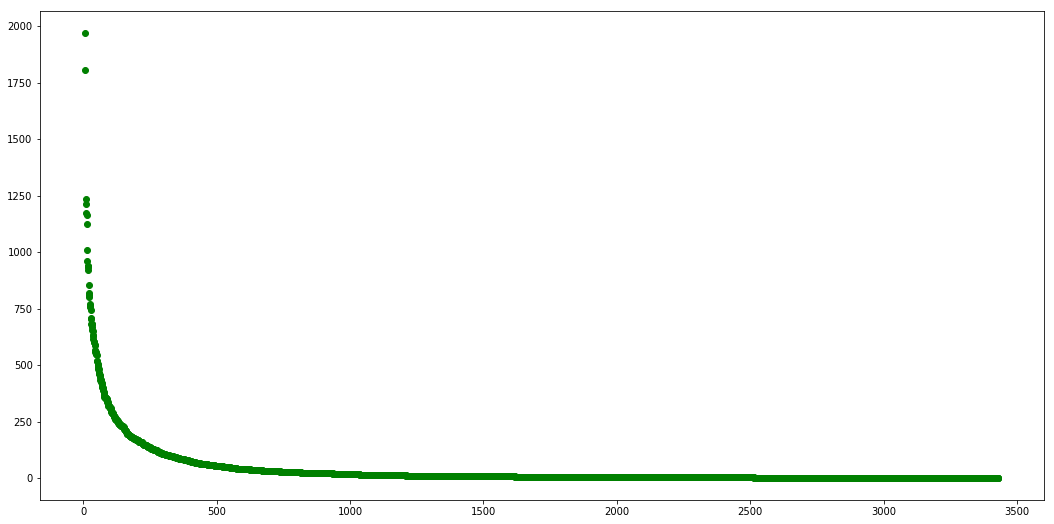

In [157]:
plt.figure(figsize=(18,9))
plt.scatter(x=wldf_new.index,y=wldf_new.freq,c='g')

In [158]:
len(wldf_new.index)

3424

In [159]:
list_words=list(wldf_new.word)

In [160]:
list_words=rem_words(list_words)

In [161]:
list_words[:5]

['unable', 'report', 'approval', 'import', 'line']

In [162]:
wldf_excU=wldf[wldf.freq.isin(wldf.freq.iloc[:1])]
wldf_excL=wldf[wldf.freq.isin(['1'])]

In [163]:
wldf_excL.head()

,word,freq
3431,dostaskmakefusionwocompleteprocess,1
3432,cuenta,1
3433,vmi,1
3434,gse,1
3435,incorporate,1


In [164]:
wldf_excU

,word,freq
0,error,3080


In [165]:
wldf_exc=pd.concat([wldf_excL,wldf_excU],axis=0)
print(wldf_exc[:2])
print(wldf_exc[-2:])

                                    word  freq
3431  dostaskmakefusionwocompleteprocess     1
3432                              cuenta     1
                word  freq
6133  categorization     1
0              error  3080


In [166]:

wldf_exc_list=list(wldf_exc.word)

In [167]:
wldf_exc_list[:5]

['dostaskmakefusionwocompleteprocess', 'cuenta', 'vmi', 'gse', 'incorporate']

In [168]:
def exc_list_word(txt):
    querywords = txt.split()
    resultwords  = [word for word in querywords if word.lower() not in wldf_exc_list]
    result = ' '.join(resultwords)
    return(result)

In [169]:
df_dict.text=df_dict.text.apply(lambda x : exc_list_word(x))

In [170]:
df_dict.text.head()

0            creation account account code combination
1    impl spt application occur edit distributions ...
2                    drilldown define financial report
3           remove assign balance segment legal entity
4        unable activate ap journal entry rule set xla
Name: text, dtype: object

#### Multinomial Naive Bayes Classifier model

In [171]:
x_train, x_test, y_train, y_test = train_test_split(df_dict.text, df_dict.Root_Cause,test_size=0.25,random_state=100)

In [172]:
vect = CountVectorizer(ngram_range=(1,3))

In [173]:
X_train = vect.fit_transform(x_train)
X_test = vect.transform(x_test)

In [174]:
mnb = MultinomialNB(0.3)
mnb.fit(X_train,y_train)
result= mnb.predict(X_test)

In [175]:
result

array(['Cloud-Implementation', 'Cloud-Implementation',
       'Cloud-Implementation', ..., 'Cloud-Implementation',
       'Cloud-Implementation', 'Cloud-Implementation'], dtype='<U29')

In [176]:
accuracy_score(result,y_test)

0.6196144174350378

In [177]:
confusion_matrix(result,y_test)

array([[3058,  917,  239,   69,   69,    4,    5,    2,   59,  110,   15],
       [ 561,  546,   71,   24,   15,    2,    0,    0,   17,   17,    6],
       [  30,   14,   57,    2,    1,    0,    0,    0,    0,    1,    0],
       [   1,    0,    0,    5,    0,    0,    0,    0,    0,    0,    0],
       [   2,    0,    0,    0,    7,    1,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    0,    0,    0,    0,    0,    0,    0,    3,    1,    0],
       [   6,    1,    0,    0,    0,    1,    0,    0,    3,   20,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [178]:
print(classification_report(result,y_test))

                               precision    recall  f1-score   support

         Cloud-Implementation       0.84      0.67      0.75      4547
           Cloud-Post Go Live       0.37      0.43      0.40      1259
           Cloud-Provisioning       0.16      0.54      0.24       105
         Cloud-Special Events       0.05      0.83      0.09         6
Cust Engmt - Customer/Partner       0.08      0.70      0.14        10
     Cust Engmt - Development       0.00      0.00      0.00         0
         Cust Engmt - Support       0.00      0.00      0.00         0
                     Hardware       0.00      0.00      0.00         0
             Software-Install       0.04      0.50      0.07         6
            Software-Maintain       0.13      0.65      0.22        31
             Software-Upgrade       0.00      0.00      0.00         1

                  avg / total       0.72      0.62      0.66      5965



#### Predict product Family for new tickets

In [71]:
new_tickets=['Error while using Oracle Cloud','Invoice Email Address" Required for EFTZ-DEV2 environment for Markel']

In [72]:
print(mnb.predict(vect.transform(new_tickets)))

['Cloud-Implementation' 'Cloud-Provisioning']
